In [239]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_curve,auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,StandardScaler
import string
import warnings
warnings.filterwarnings('ignore')

SEED = 42


In [240]:
def concat_df(train_data, test_data):
    # Returns a concatenated df of training and test set
    return pd.concat([train_data, test_data], sort=True).reset_index(drop=True)


def devide_df(all_data):
    # Returns divided dfs of training and test set
    return all_data.loc[:890], all_data.loc[891:].drop(['Survived'], axis=1)

In [241]:
df_train = pd.read_csv('/Users/duoduo/Desktop/讲义/pandas/泰坦尼克/train.csv')
df_test = pd.read_csv('/Users/duoduo/Desktop/讲义/pandas/泰坦尼克/test.csv')

df_all =concat_df(df_train,df_test)
df_train.name = 'training set'
df_test.name = 'test set'
df_all.name = 'all set'

dfs = [df_train, df_test]

In [242]:
print('Number of Training Examples = {}'.format(df_train.shape[0]))
print('Number of Test Examples = {}\n'.format(df_test.shape[0]))
print('Training X Shape = {}'.format(df_train.shape))
print('Training y Shape = {}\n'.format(df_train['Survived'].shape[0]))
print('Test X Shape = {}'.format(df_test.shape))
print('Test y Shape = {}\n'.format(df_test.shape[0]))
print(df_train.columns)
print(df_test.columns)

Number of Training Examples = 891
Number of Test Examples = 418

Training X Shape = (891, 12)
Training y Shape = 891

Test X Shape = (418, 11)
Test y Shape = 418

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


## 1.missing values

In [243]:
def display_missing(df):
    for col in df.columns.tolist():
        print('{} column missing values : {}'.format(col,df[col].isnull().sum()))

for df in dfs:
    print('{}'.format(df.name))
    display_missing(df)
    print('-'*40)

training set
PassengerId column missing values : 0
Survived column missing values : 0
Pclass column missing values : 0
Name column missing values : 0
Sex column missing values : 0
Age column missing values : 177
SibSp column missing values : 0
Parch column missing values : 0
Ticket column missing values : 0
Fare column missing values : 0
Cabin column missing values : 687
Embarked column missing values : 2
----------------------------------------
test set
PassengerId column missing values : 0
Pclass column missing values : 0
Name column missing values : 0
Sex column missing values : 0
Age column missing values : 86
SibSp column missing values : 0
Parch column missing values : 0
Ticket column missing values : 0
Fare column missing values : 1
Cabin column missing values : 327
Embarked column missing values : 0
----------------------------------------


#### 1.1 age

Age中的缺失值用年龄中位数填充，但使用整个数据集的年龄中位数并不是一个好的选择。

Pclass组中位年龄与age(0.408106)、survived(0.338481)相关性高，是最佳选择。

按乘客等级来划分年龄比按其他特征来划分年龄更符合逻辑。

In [244]:
# unstack 将矩阵转化为三列series
df_all_corr = df_all.corr().abs().unstack().sort_values(kind='quicksort',ascending=False).reset_index()
df_all_corr.rename(columns={'level_0':'feature_1','level_1':'feature_2',0:'correlation'},inplace=True)
df_all_corr.query('feature_1 == "Age"')

,feature_1,feature_2,correlation
0,Age,Age,1.000000
9,Age,Pclass,0.408106
18,Age,SibSp,0.243699
21,Age,Fare,0.178740
26,Age,Parch,0.150917
30,Age,Survived,0.077221
41,Age,PassengerId,0.028814


In [245]:
age_by_pclass_sex = df_all.groupby(['Sex', 'Pclass']).median()['Age']

for pclass in range(1, 4):
    for sex in ['female', 'male']:
        print('Median age of Pclass {} - {}s: {}'.format(pclass, sex, age_by_pclass_sex[sex][pclass]))

print('Median age of all passengers: {}'.format(df_all['Age'].median()))

# Filling the missing values in Age with the medians of Sex and Pclass groups
df_all['Age'] = df_all.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))

Median age of Pclass 1 - females: 36.0
Median age of Pclass 1 - males: 42.0
Median age of Pclass 2 - females: 28.0
Median age of Pclass 2 - males: 29.5
Median age of Pclass 3 - females: 22.0
Median age of Pclass 3 - males: 25.0
Median age of all passengers: 28.0


#### 1.2 embarked

In [246]:
df_all[df_all.Embarked.isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
61,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572
829,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572


In [247]:
df_all['Embarked'] = df_all['Embarked'].fillna('S')

#### 1.3 Fare

In [248]:
df_all[df_all.Fare.isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
1043,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701


In [249]:
# 计算船舱等级为3、父母子女数量为0、兄弟姐妹配偶数量为0的情况下的船票价格（'Fare'）的中位数。这可以用于获取特定组合的中位数价格

med_fare = df_all.groupby(['Pclass','Parch','SibSp']).Fare.median()[3][0][0]
df_all['Fare'] = df_all['Fare'].fillna(med_fare)


In [250]:
df_all[df_all.Cabin.notnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
6,54.0,E46,S,51.8625,"McCarthy, Mr. Timothy J",0,7,1,male,0,0.0,17463
10,4.0,G6,S,16.7000,"Sandstrom, Miss. Marguerite Rut",1,11,3,female,1,1.0,PP 9549
11,58.0,C103,S,26.5500,"Bonnell, Miss. Elizabeth",0,12,1,female,0,1.0,113783
...,...,...,...,...,...,...,...,...,...,...,...,...
1295,43.0,D40,C,27.7208,"Frauenthal, Mr. Isaac Gerald",0,1296,1,male,1,NaN,17765
1296,20.0,D38,C,13.8625,"Nourney, Mr. Alfred (Baron von Drachstedt"")""",0,1297,2,male,0,NaN,SC/PARIS 2166
1298,50.0,C80,C,211.5000,"Widener, Mr. George Dunton",1,1299,1,male,1,NaN,113503
1302,37.0,C78,Q,90.0000,"Minahan, Mrs. William Edward (Lillian E Thorpe)",0,1303,1,female,1,NaN,19928


### 1.4 Cabin

cabin有点棘手，需要进一步探索。很大一部分被忽略了，而这个功能本身也不能被完全忽略，因为有些cabin可能有更高的存活率。客舱的第一个字母代表客舱所在的甲板。这些甲板主要用于一个乘客等级，但其中一些可供多个乘客等级使用。

In [251]:
# 创建新列，将cabin的第一个字母提取出来;s[0]提取cabin列值的第一个字符，也就是船舱号码首字母；
# if条件语句，如果cabin列的值不是缺失（即不是nan)，则返回提取首字母，否则返回'M‘表示缺失
df_all['Deck'] = df_all['Cabin'].apply(lambda s : s[0] if pd.notnull(s) else 'M')

# 按deck和pclass分组，对每个分组计算非nan的数量；包含了每个deck和pclass组合的乘客数；
# transpose()转制操作，行和列互换
df_all_decks = df_all.groupby(['Deck','Pclass']).count().drop(columns=['Survived', 'Sex', 'Age', 'SibSp', 'Parch','Fare', 'Embarked', 'Cabin', 'PassengerId', 'Ticket']).rename(columns={'Name':'count'}).transpose()
df_all_decks

Deck     A   B   C   D      E         F     G   M            T
Pclass   1   1   1   1  2   1  2  3   2  3  3   1    2    3  1
count   22  65  94  40  6  34  4  3  13  8  5  67  254  693  1

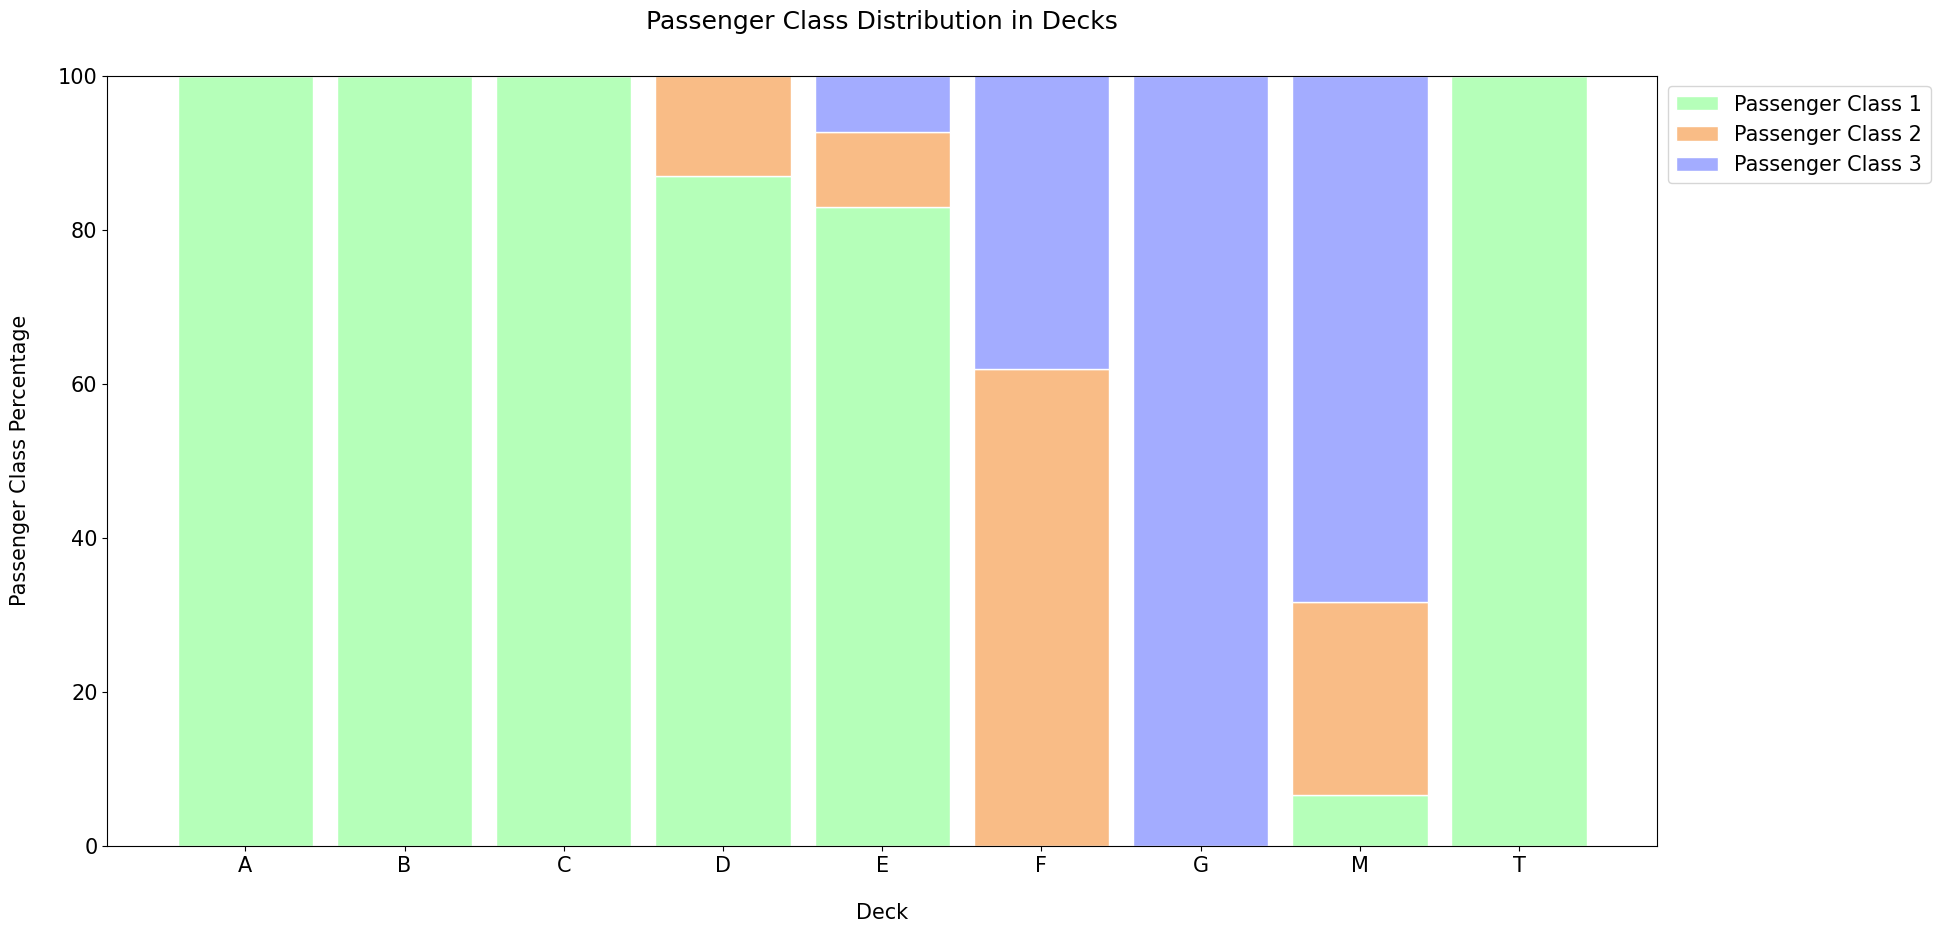

In [252]:
# 这个函数接受一个DataFrame df 作为参数，用于计算不同甲板上不同仓位等级的分布情况。
# 它返回两个字典：deck_counts 包含每个甲板上每个仓位等级的乘客数量，deck_percentages 包含每个甲板上每个仓位等级的乘客比例。

def get_pcalss_dist(df):
    deck_counts = {'A': {}, 'B': {}, 'C': {}, 'D': {}, 'E': {}, 'F': {}, 'G': {}, 'M': {}, 'T': {}}
    decks = df.columns.levels[0]

    for deck in decks:
        for pclass in range(1,4):
            try:
                count = df[deck][pclass][0]
                deck_counts[deck][pclass] = count
            except KeyError:
                deck_counts[deck][pclass] = 0
    df_decks = pd.DataFrame(deck_counts)
    deck_percentage = {}

    for col in df_decks.columns:
        deck_percentage[col] = [(count / df_decks[col].sum()) * 100 for count in df_decks[col]]
    return deck_counts,deck_percentage


def display_pclass_dist(percentages):
    
    df_percentages = pd.DataFrame(percentages).transpose()
    deck_names = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'M', 'T')
    bar_count = np.arange(len(deck_names))  
    bar_width = 0.85
    
    pclass1 = df_percentages[0]
    pclass2 = df_percentages[1]
    pclass3 = df_percentages[2]
    
    plt.figure(figsize=(20, 10))
    plt.bar(bar_count, pclass1, color='#b5ffb9', edgecolor='white', width=bar_width, label='Passenger Class 1')
    plt.bar(bar_count, pclass2, bottom=pclass1, color='#f9bc86', edgecolor='white', width=bar_width, label='Passenger Class 2')
    plt.bar(bar_count, pclass3, bottom=pclass1 + pclass2, color='#a3acff', edgecolor='white', width=bar_width, label='Passenger Class 3')

    plt.xlabel('Deck', size=15, labelpad=20)
    plt.ylabel('Passenger Class Percentage', size=15, labelpad=20)
    plt.xticks(bar_count, deck_names)    
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)
    
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 15})
    plt.title('Passenger Class Distribution in Decks', size=18, y=1.05)   
    
    plt.show()   


all_deck_count, all_deck_per = get_pcalss_dist(df_all_decks)
display_pclass_dist(all_deck_per)

100% of A,B,C decks 在 1 class 

deck D 有87%  1 class ，13%  2 class

deck E:83% 1 class,10 2nd，7% 3rd

Deck F has 62% 2nd class and 38% 3rd class passengers

100% of G deck are 3rd class passengers

T舱甲板上有一个人，他是头等舱乘客。T舱乘客与A甲板乘客最相似，所以他被归为A甲板

标记为M的乘客是客舱特征中缺失的值。我认为不可能找到那些乘客真正的甲板，所以我决定把M当作甲板使用

In [253]:
# passenger in the t deck is changed to a
idx = df_all.query('Deck == "T"').index
df_all.loc[idx,'Deck'] ='A'

In [254]:
df_all_decks_survived = df_all.groupby(['Deck','Survived']).count().drop(columns=['Sex', 'Age', 'SibSp', 'Parch', 'Fare','Embarked', 'Pclass', 'Cabin', 'PassengerId', 'Ticket' ]).rename(columns={'Name':'count'}).transpose()
df_all_decks_survived

Deck       A       B       C       D       E       F       G        M     
Survived 0.0 1.0 0.0 1.0 0.0 1.0 0.0 1.0 0.0 1.0 0.0 1.0 0.0 1.0  0.0  1.0
count      9   7  12  35  24  35   8  25   8  24   5   8   2   2  481  206

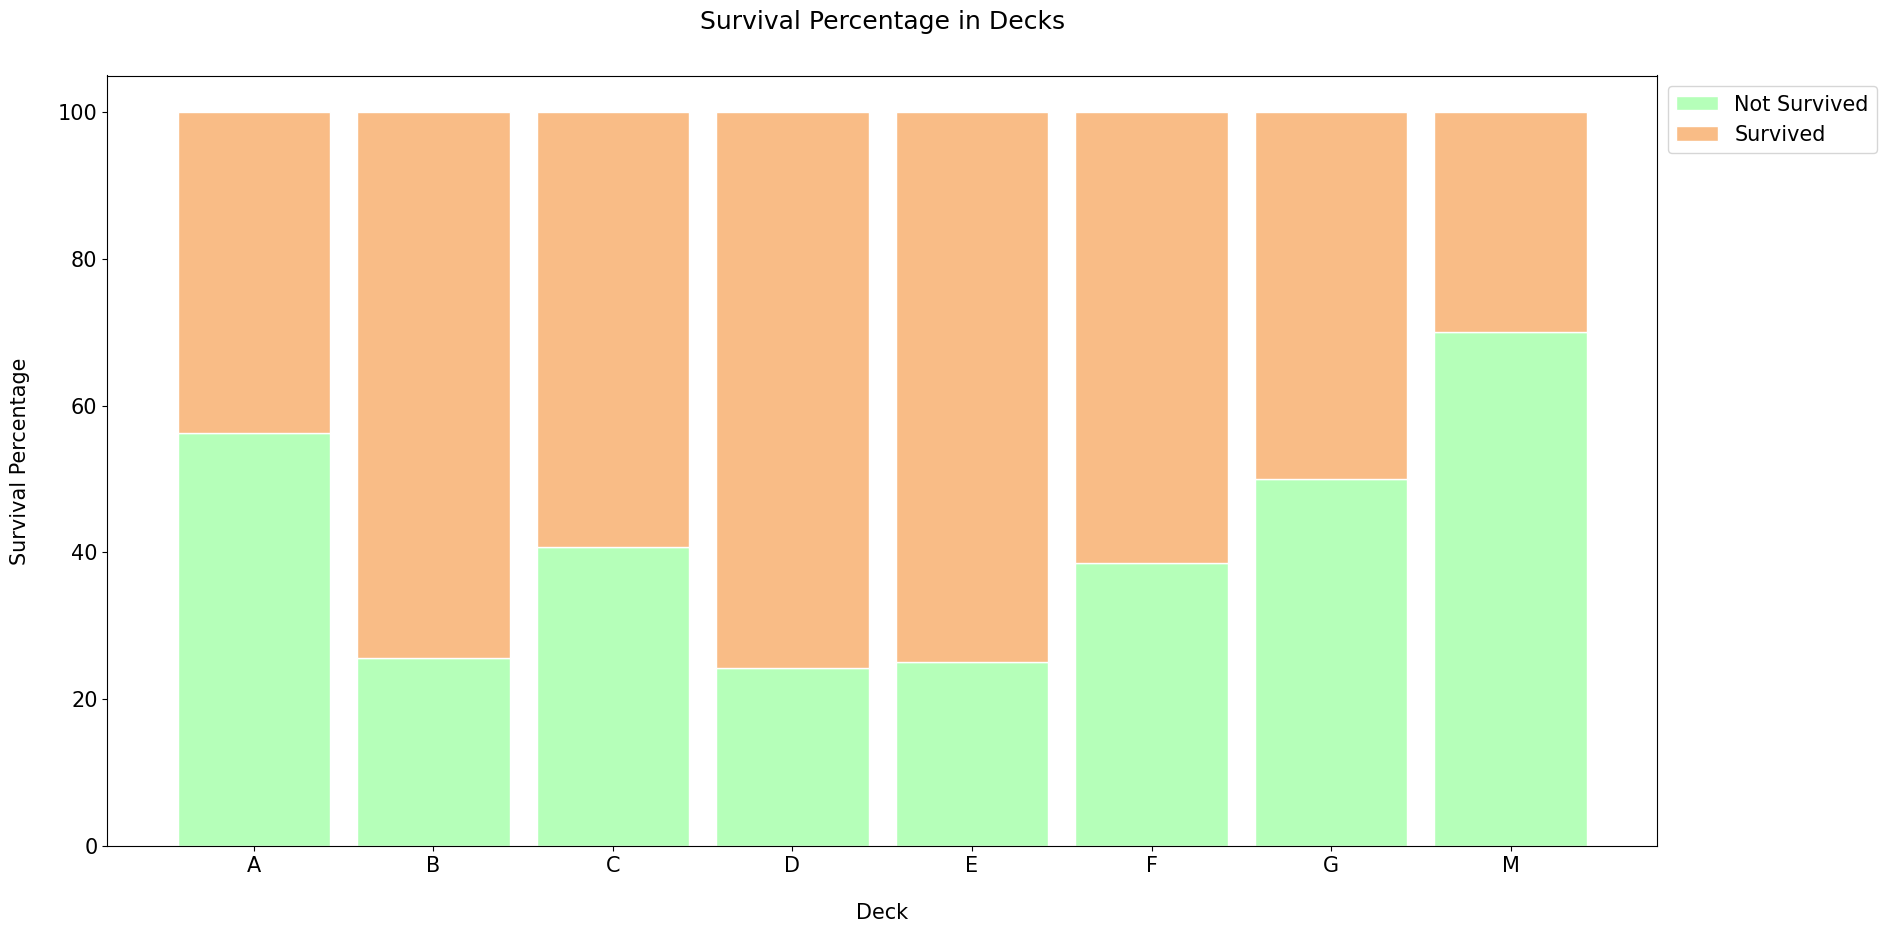

In [255]:
def get_survived_dist(df):
    surv_counts = {'A':{}, 'B':{}, 'C':{}, 'D':{}, 'E':{}, 'F':{}, 'G':{}, 'M':{}}
    decks = df.columns.levels[0]    

    for deck in decks:
        for survive in range(0, 2):
            surv_counts[deck][survive] = df[deck][survive][0]
            
    df_surv = pd.DataFrame(surv_counts)
    surv_percentages = {}

    for col in df_surv.columns:
        surv_percentages[col] = [(count / df_surv[col].sum()) * 100 for count in df_surv[col]]
        
    return surv_counts, surv_percentages

def display_surv_dist(percentages):
    
    df_survived_percentages = pd.DataFrame(percentages).transpose()
    deck_names = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'M')
    bar_count = np.arange(len(deck_names))  
    bar_width = 0.85    

    not_survived = df_survived_percentages[0]
    survived = df_survived_percentages[1]
    
    plt.figure(figsize=(20, 10))
    plt.bar(bar_count, not_survived, color='#b5ffb9', edgecolor='white', width=bar_width, label="Not Survived")
    plt.bar(bar_count, survived, bottom=not_survived, color='#f9bc86', edgecolor='white', width=bar_width, label="Survived")
    plt.xlabel('Deck', size=15, labelpad=20)
    plt.ylabel('Survival Percentage', size=15, labelpad=20)
    plt.xticks(bar_count, deck_names)    
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)
    
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 15})
    plt.title('Survival Percentage in Decks', size=18, y=1.05)
    
    plt.show()

all_surv_count, all_surv_per = get_survived_dist(df_all_decks_survived)
display_surv_dist(all_surv_per)

正如怀疑的，每个deck都有不同的存活率，这些信息不能被丢弃。甲板B、C、D和E的存活率最高。那些甲板上大多是头等舱乘客。M的存活率最低，主要由二等和三等舱乘客占据。综上所述，头等舱乘客使用的客舱比二等舱和三等舱乘客使用的客舱存活率更高。我认为M (Missing Cabin values)的存活率最低，因为他们无法检索到受害者的船舱数据。这就是为什么我认为将该组标记为M是处理丢失数据的合理方法。这是一个具有共同特点的独特群体。Deck特征现在具有高基数性，因此一些值根据它们的相似性彼此分组。

A、B、C层被标为ABC，因为它们都只有一等舱乘客

D和E甲板被标记为DE，因为它们都具有相似的乘客等级分布和相同的存活率

由于同样的原因，F和G甲板被标记为FG

M deck不需要与其他套牌组合在一起，因为它与其他套牌非常不同，并且存活率最低。

In [256]:
df_all['Deck'] = df_all['Deck'].replace(['A','B','C'],'ABC')
df_all['Deck'] = df_all['Deck'].replace(['D','E'],'DE')
df_all['Deck'] = df_all['Deck'].replace(['F','G'],'FG')
df_all['Deck'].value_counts()

M      1014
ABC     182
DE       87
FG       26
Name: Deck, dtype: int64

#### 1.5 target distribution

In [257]:
survived = df_train['Survived'].value_counts()[1]
not_survived = df_train['Survived'].value_counts()[0]

survived_per = survived / df_train.shape[0] * 100
not_survived_per = not_survived / df_train.shape[0] * 100

print('{} of {} pessenger survived and it is the {:.2f}% of the train set.'.format(survived,df_train.shape[0],survived_per))
print('{} of {} pessenger not survived and it is the {:.2f}% of the train set.'.format(not_survived,df_train.shape[0],not_survived_per))

342 of 891 pessenger survived and it is the 38.38% of the train set.
549 of 891 pessenger not survived and it is the 61.62% of the train set.


Text(0, 0.5, 'pessenger count')

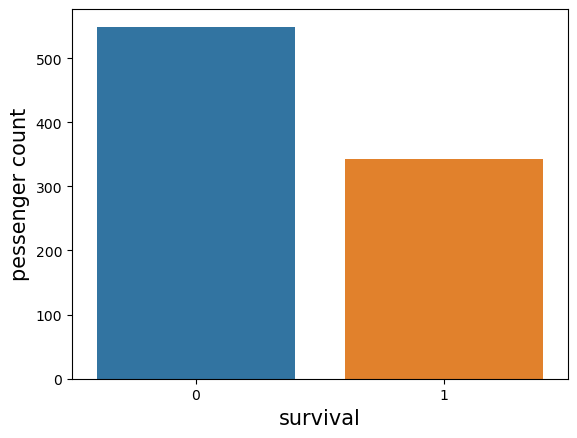

In [258]:
sns.countplot(df_train.Survived)

plt.xlabel('survival',size=15)
plt.ylabel('pessenger count',size=15)

In [259]:
import plotly.express as px

In [260]:
survived_counts = df_train.Survived.value_counts()
per = survived_counts / len(df_train)*100
fig = px.pie(
    values=per,
    names=survived_counts.index,
    labels={'0':'no-survived','1':'survived'},
    title='survived pecentage'
)
fig.show()

# 1.6相关
 - fare-pclass 0.549500
 - parch-sibsp 0.414838

In [261]:
df_train_corr = df_train.drop(['PassengerId'],axis=1).corr().abs().unstack().sort_values(kind='quicksort',ascending=False).reset_index()

df_train_corr.rename(columns={'level_0':'feature_1','level_1':'feature_2',0:'corr'},inplace=True)
df_train_corr.drop(df_train_corr.iloc[1::2].index)

df_train_corr_nd = df_train_corr.drop(df_train_corr[df_train_corr['corr']==1.0].index)

corr = df_train_corr_nd['corr']>0.1
df_train_corr_nd[corr]

,feature_1,feature_2,corr
6,Fare,Pclass,0.549500
7,Pclass,Fare,0.549500
8,Parch,SibSp,0.414838
9,SibSp,Parch,0.414838
10,Age,Pclass,0.369226
11,Pclass,Age,0.369226
12,Survived,Pclass,0.338481
13,Pclass,Survived,0.338481
14,SibSp,Age,0.308247
15,Age,SibSp,0.308247


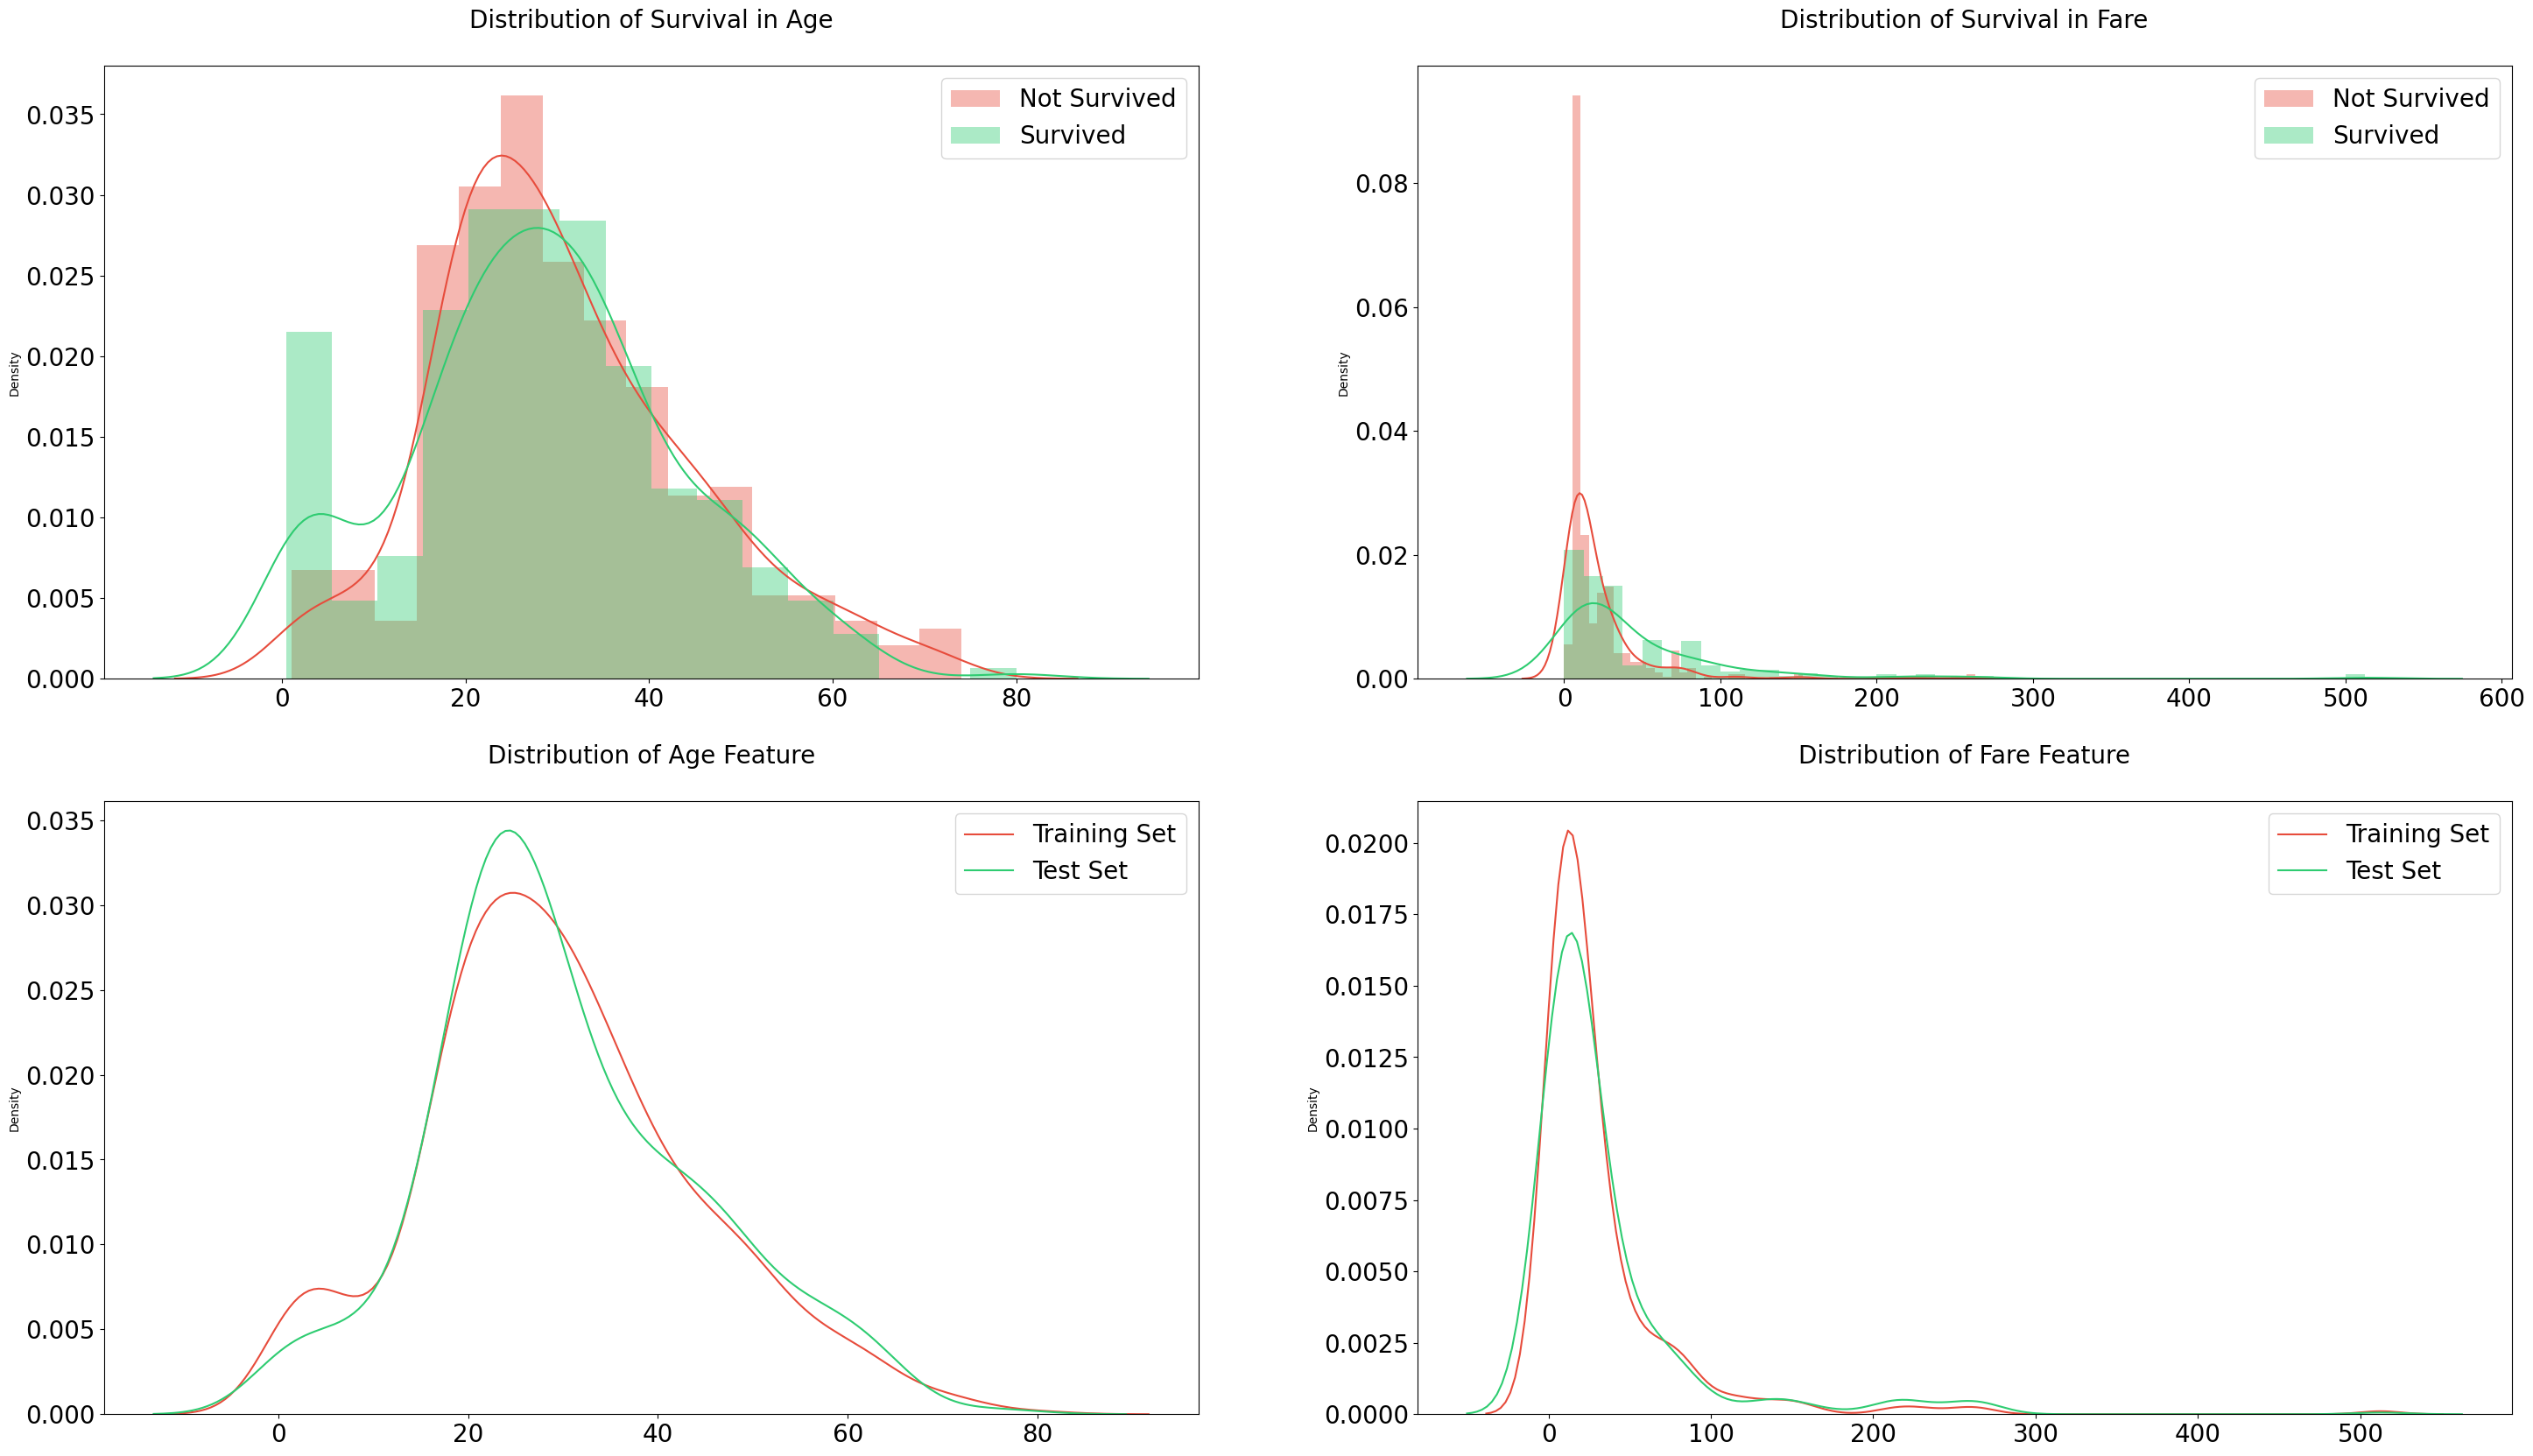

In [262]:
cont_features = ['Age', 'Fare']
surv = df_train['Survived'] == 1

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(20, 20))
plt.subplots_adjust(right=1.5)

for i, feature in enumerate(cont_features):    
    # Distribution of survival in feature
    sns.distplot(df_train[~surv][feature], label='Not Survived', hist=True, color='#e74c3c', ax=axs[0][i])
    sns.distplot(df_train[surv][feature], label='Survived', hist=True, color='#2ecc71', ax=axs[0][i])
    
    # Distribution of feature in dataset
    sns.distplot(df_train[feature], label='Training Set', hist=False, color='#e74c3c', ax=axs[1][i])
    sns.distplot(df_test[feature], label='Test Set', hist=False, color='#2ecc71', ax=axs[1][i])
    
    axs[0][i].set_xlabel('')
    axs[1][i].set_xlabel('')
    
    for j in range(2):        
        axs[i][j].tick_params(axis='x', labelsize=20)
        axs[i][j].tick_params(axis='y', labelsize=20)
    
    axs[0][i].legend(loc='upper right', prop={'size': 20})
    axs[1][i].legend(loc='upper right', prop={'size': 20})
    axs[0][i].set_title('Distribution of Survival in {}'.format(feature), size=20, y=1.05)

axs[1][0].set_title('Distribution of {} Feature'.format('Age'), size=20, y=1.05)
axs[1][1].set_title('Distribution of {} Feature'.format('Fare'), size=20, y=1.05)
        
plt.show()

ValueError: Could not interpret input 'Deck'

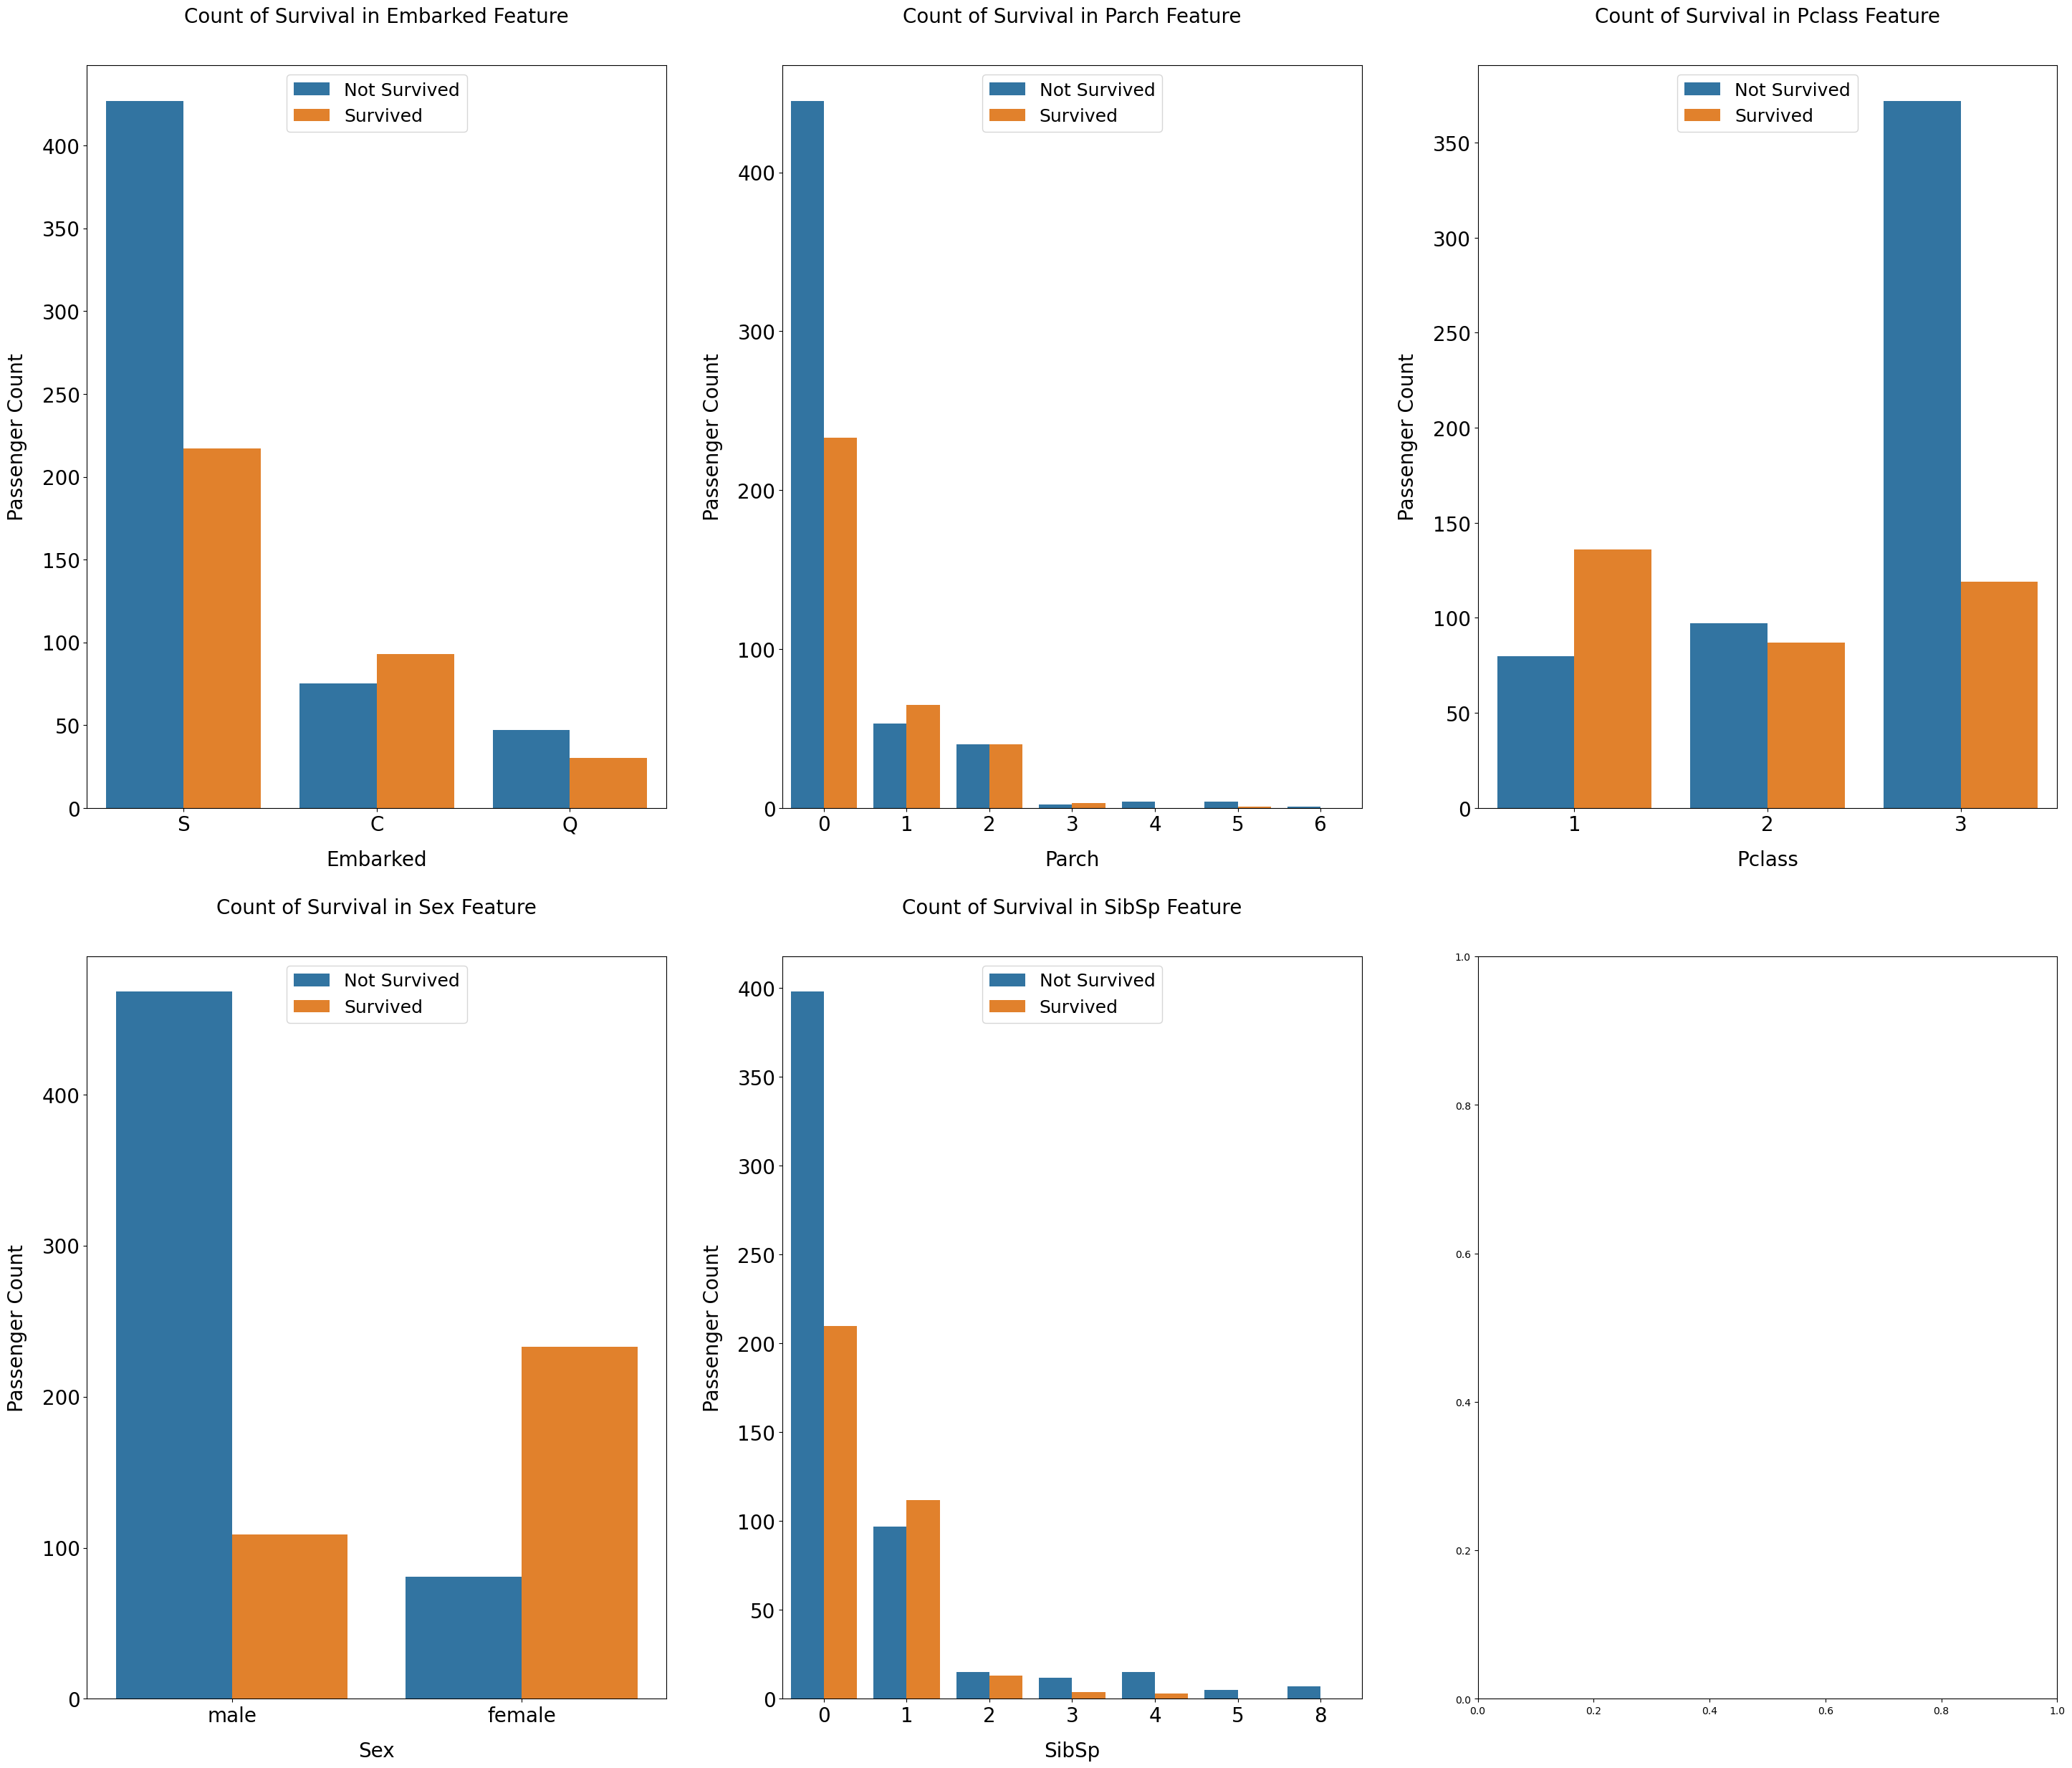

In [263]:
cat_features = ['Embarked', 'Parch', 'Pclass', 'Sex', 'SibSp', 'Deck']

fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(20, 20))
plt.subplots_adjust(right=1.5, top=1.25)

for i, feature in enumerate(cat_features, 1):    
    plt.subplot(2, 3, i)
    sns.countplot(x=feature, hue='Survived', data=df_train)
    
    plt.xlabel('{}'.format(feature), size=20, labelpad=15)
    plt.ylabel('Passenger Count', size=20, labelpad=15)    
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)
    
    plt.legend(['Not Survived', 'Survived'], loc='upper center', prop={'size': 18})
    plt.title('Count of Survival in {} Feature'.format(feature), size=20, y=1.05)

plt.show()

大多数特征都是相互关联的。这种关系可以通过特征转换（归一化标准化等）和特征交互来创建新的特征。目标编码（）将分类特征映射到目标变量的均值火概率的方法。也非常有用，因为它与 Survived 特征高度相关。

在连续特征中可以看到分割点和尖峰。使用决策树模型可以轻松捕捉到它们，但线性模型可能无法发现它们。

分类特征具有非常明显的分布，存活率各不相同。这些特征可以进行单次编码（one_hot_encoding）。其中一些特征可以相互组合，形成新的特征。



## 特征工程
### 1.连续数据特征--binning
    1、fare

票价特征呈正倾斜，右端存活率极高。票价特征使用了 13 个基于量化的分段。尽管分段过多，但还是提供了相当数量的信息增益。图中左侧组别的存活率最低，右侧组别的存活率最高。这种高存活率在分布图中并不明显。中间还有一个不寻常的组（15.742, 23.25]，存活率很高，在此过程中被捕捉到了。

In [269]:
df_all['Fare'] = pd.qcut(df_all['Fare'],13)

Text(0, 0.5, 'Count')

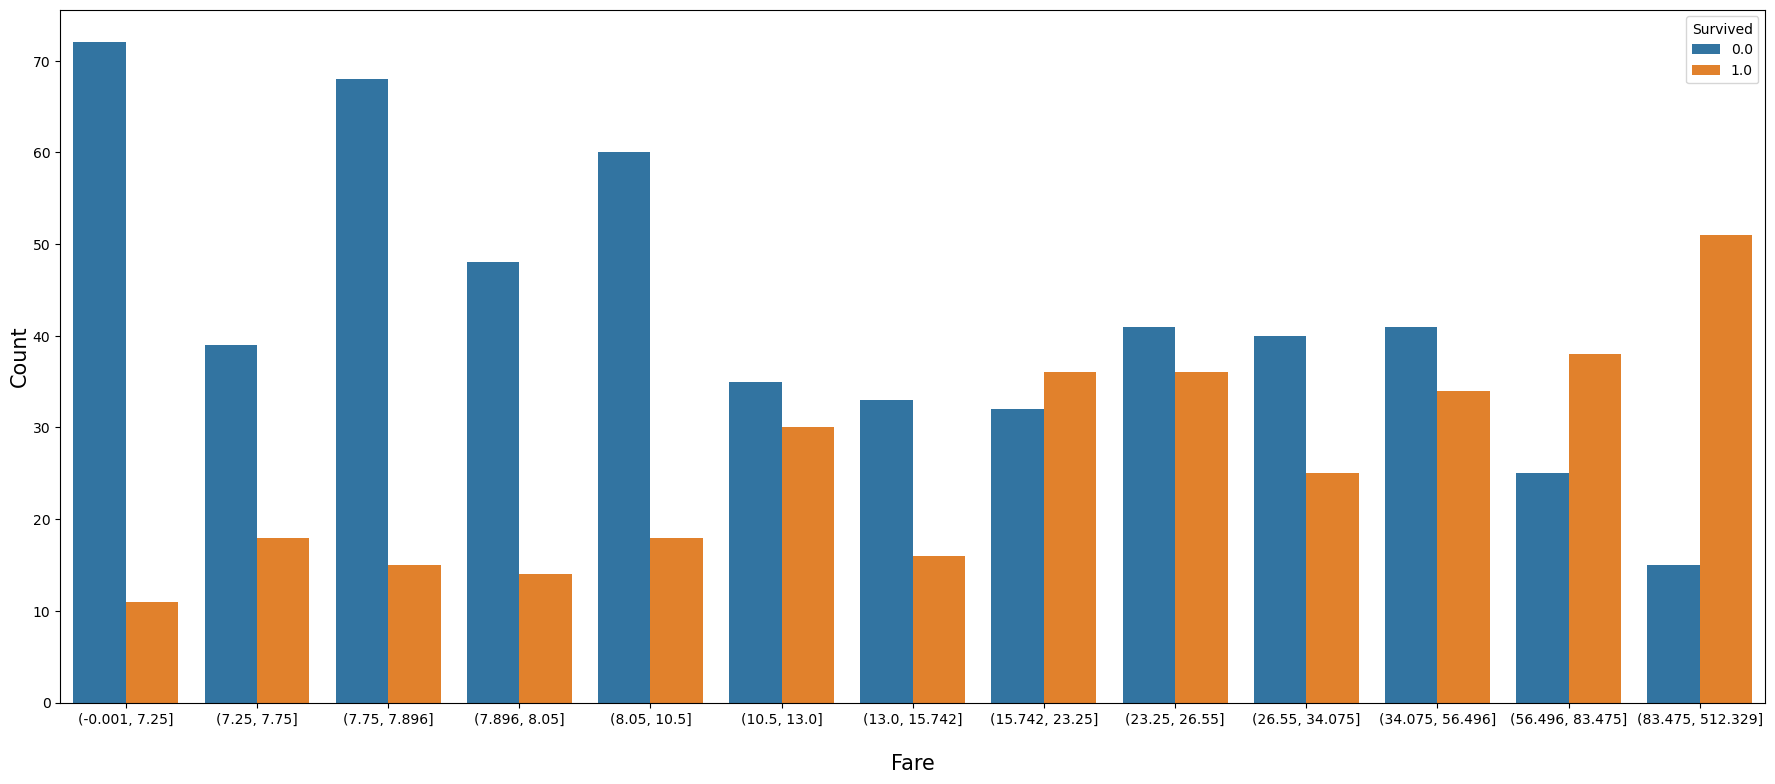

In [270]:
fig,axs = plt.subplots(figsize=(22,9))
sns.countplot(x='Fare',hue='Survived',data=df_all)

plt.xlabel('Fare',size=15,labelpad=20)
plt.ylabel('Count',size=15,labelpad=2)

## age

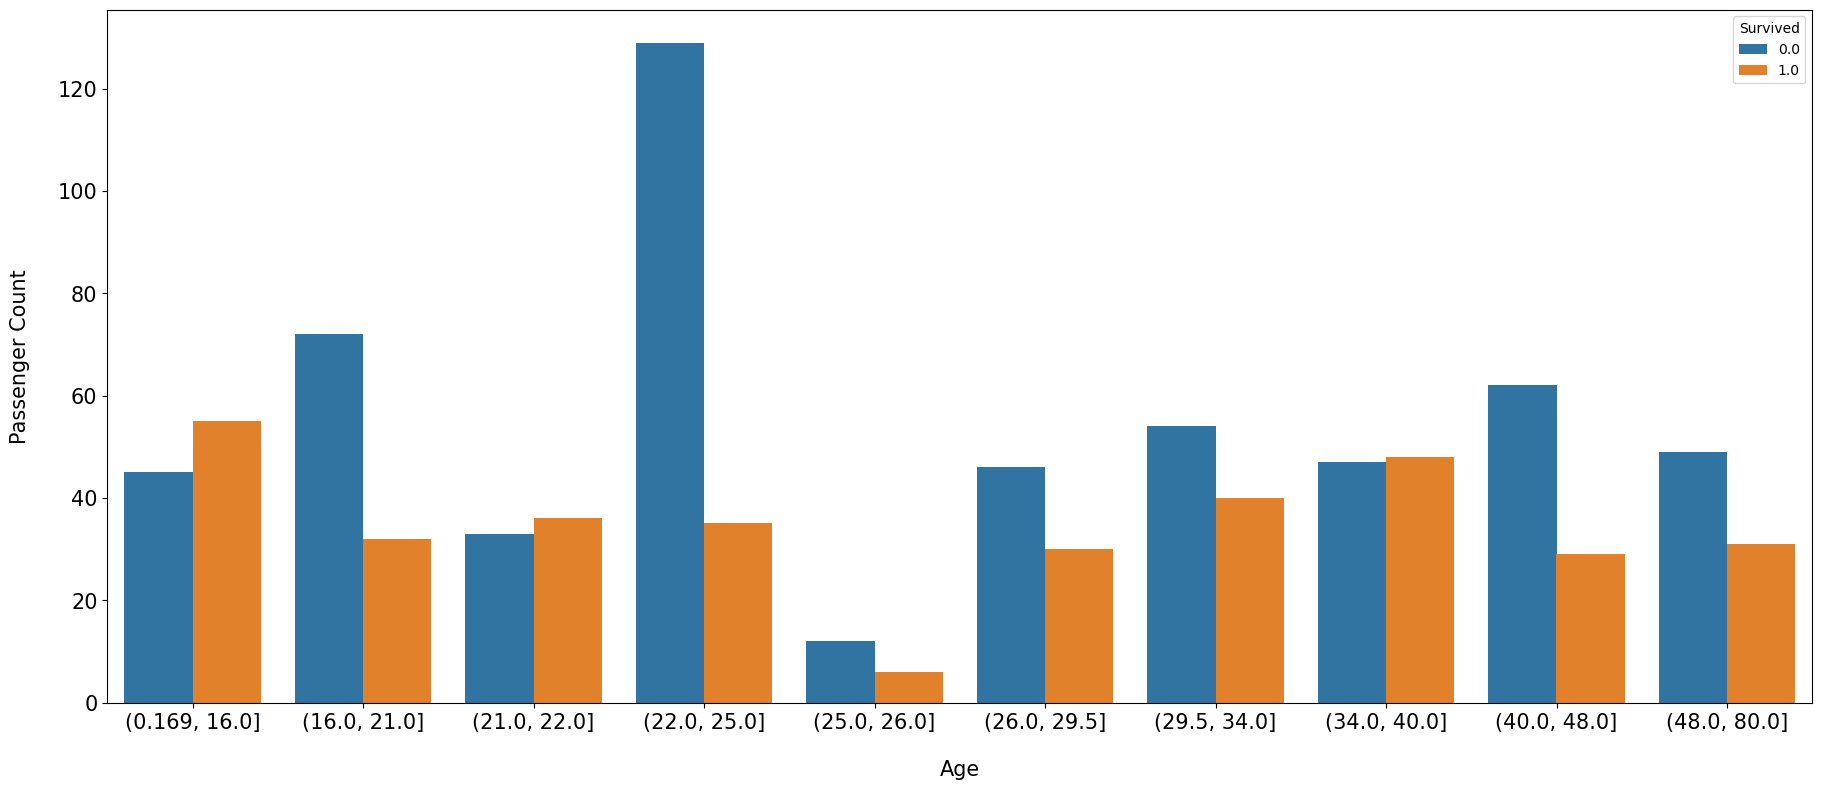

In [266]:
fig, axs = plt.subplots(figsize=(22, 9))
df_all['Age'] = pd.qcut(df_all['Age'],10)
sns.countplot(data=df_all,x='Age',hue='Survived')

plt.xlabel('Age', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)

第一个bin 存活最高；第四个存活最低

## family encode 
    sibsp、parch、1 构成一个家庭的人数；
    family=1 alone
    family = 2,3,4 small
    family= 5,6,median
    family=7,8,11 large

In [277]:
df_all['family_size'] = df_all.SibSp + df_all.Parch +1

In [279]:
df_all.family_size.value_counts()

1     790
2     235
3     159
4      43
6      25
5      22
7      16
11     11
8       8
Name: family_size, dtype: int64

<AxesSubplot:>

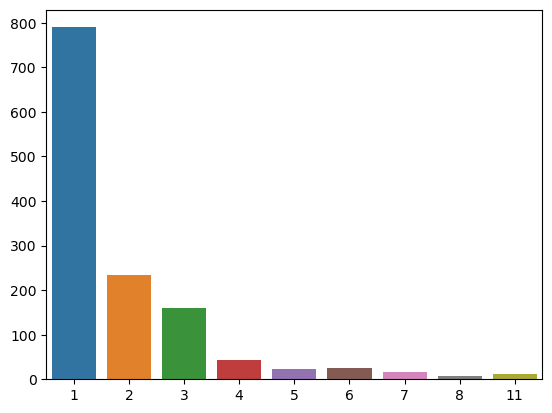

In [280]:
fig,axs = plt.subplots(figsize=(20,20),nrows=2,ncols=2)
plt.subplots_adjust(right=1.5)

sns.barplot(x=df_all.family_size.value_counts().index,y=df_all.family_size.value_counts().values)